# Simulating flow

To use `bluebonnet.flow` in a project:

In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d,UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy import interpolate
from lmfit import minimize, Parameters,report_errors,conf_interval,Minimizer,printfuncs
from matplotlib.backends.backend_pdf import PdfPages
from FitFunctions import obfun

from bluebonnet.flow import (
    IdealReservoir, FlowProperties, FlowPropertiesMarder, FlowPropertiesTwoPhase, 
    SinglePhaseReservoir, SinglePhaseReservoirMarder,RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure
from bluebonnet import plotting

Results={}

#import sys
#sys.path.insert(0,"/Users/michaelmarder/UTOneDrive/OneDrive - The University of Texas at Austin/Shale/bluebonnet/src/")
#plt.style.use("ggplot")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def plot_pseudopressure(reservoir, rescale=False,ax=None,xmax=1,mbot=0,mtop=1.05):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(1/reservoir.nx, 1, reservoir.nx)
    pinit=reservoir.pseudopressure[0,-1]
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            if rescale:
                pscale=(p-p[0])/(pinit-p[0])
                ax.plot(x,pscale, color='steelblue')
            else:
                ax.plot(x,p, color='steelblue')
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, xmax), ylim=(mbot,mtop))
    return fig, ax

def plot_recovery_rate(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    rate=reservoir.rate
    time = reservoir.time
    ax.plot(time, rate)
    ax.set(xscale='log', yscale='log',ylim=(1.e-4, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax

def plot_recovery_factor(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale='squareroot', ylim=(0, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax


In [8]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2


## Real gas simulation

In [96]:
Pi=12000
Pf=1000
Pf=5000

n_times=1000


t_end = 20
time = np.linspace(0, np.sqrt(t_end), n_times) ** 2
PressureTime=np.ones(n_times)
for i in range(n_times):
    if i<n_times/4: 
        PressureTime[i]=Pf 
    elif i<n_times/2:
        PressureTime[i]=Pf/2 
    else: 
        PressureTime[i]=Pf/4


pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")

ms=2*cumtrapz(pvt_gas.P/(pvt_gas.Viscosity*pvt_gas["Z-Factor"]),pvt_gas.P)
ms=np.concatenate(([0],ms))
pvt_gas.pseudopressure=ms
#pvt_gas.Cg=1./pvt_gas.P-1/pvt_gas["Z-Factor"]*Zfunc.derivative()(pvt_gas.P)


flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)
density_interp = interpolate.interp1d(flow_propertiesM.df["m_scaled"], flow_propertiesM.df["Density"])

print('mf=',flow_propertiesM.m_scaled_func(Pf))

res_realgasM = SinglePhaseReservoirMarder(100, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(time,PressureTime=PressureTime)

rf2M = res_realgasM.recovery_factor()
rf2M[-1]


mf= 0.09660769499003893
CPU times: user 3.12 s, sys: 28.4 ms, total: 3.15 s
Wall time: 3.17 s


0.8276580948155892

0.3631517889980861
0.09660769499003893 0.007089359639632412 Devation is -0.79%


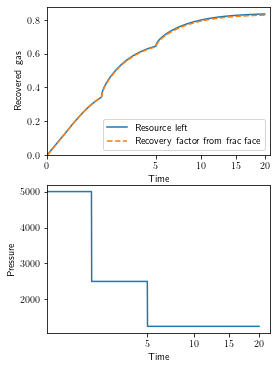

In [98]:
from scipy import interpolate
density_interp = interpolate.interp1d(flow_propertiesM.df["m_scaled"], flow_propertiesM.df["Density"])

def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt.df["m_scaled"], pvt.df["Density"])
    print(max(pvt.df["m_scaled"]))
    p=np.minimum(pseudopressure,max(pvt.df["m_scaled"]))
    return (density(p)).sum(axis=1)/len(pseudopressure[0])
mf=flow_propertiesM.m_scaled_func(Pf)
mi=flow_propertiesM.m_scaled_func(Pi)


remaining_gasM = (resource_left(res_realgasM.pseudopressure, flow_propertiesM) )/(density_interp(mi))
print(mf,res_realgasM.pseudopressure[-1][0],'Devation is {:5.2g}%'.format((rf2M[-1]-1+remaining_gasM[-1])/rf2M[-1]*100))
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(4, 6)
ax1.plot(time, 1 - remaining_gasM, label="Resource left")
ax1.plot(time, rf2M,"--", label="Recovery factor from frac face")
ax1.legend()
ax1.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

ax2.plot(time, PressureTime , label="Pressure")
ax2.set(xlabel="Time",  xscale='squareroot',ylabel="Pressure")

pp=PdfPages('PressureCheck.pdf')
pp.savefig(fig)
pp.close()

In [110]:
D

Unnamed: 0        Days       Gas      Oil    Water     Pressure
0             3    1.625000  0.000000     0.00   102.00  6281.546753
1             4    1.666667  0.000000     0.00   103.00  6282.200099
2             5    1.708333  0.000000     0.00   101.00  6275.901095
3             6    1.750000  0.000000     0.00   115.00  6315.124140
4             7    1.791667  0.000000     0.00   126.00  6311.044420
5             8    1.833333  0.000000     1.00   121.00  6272.281351
6             9    1.875000  0.000000     1.00   127.00  6308.592936
7            10    1.916667  0.000000     2.00   121.00  6261.363704
8            11    1.958333  0.000000     2.00   126.00  6292.273897
9            12    2.000000  0.000000     1.00   120.00  6235.301270
10           13    2.041667  0.000000     0.00    89.00  6288.725147
11           14    2.083333  0.000000     0.00    90.00  6289.732618
12           15    2.125000  0.000000     0.00    82.00  6244.755557
13           16    2.166667  0.000000     0.00    95.00  6304.603438
14           17    2.208333  0.000000     0.00    87.00  6256.601196
15           18    2.250000  0.000000     0.00    84.00  6236.026978
16           19    2.291667  0.000000     0.00    89.00  6254.430761
17           20    2.333333  0.000000     0.00    82.00  6215.501936
18           21    2.375000  0.000000     0.00    88.00  6238.343243
19           22    2.416667  0.000000     0.00    98.00  6285.486923
20           23    2.458333  0.000000     0.00   102.00  6304.741988
21           24    2.500000  0.000000     0.00    92.00  6243.485005
22           25    2.541667  0.000000     0.00    96.00  6258.510342
23           26    2.583333  0.000000     0.00   102.00  6288.606181
24           27    2.625000  0.000000     0.00   102.00  6281.546753
25           28    2.666667  0.000000     0.00   103.00  6282.200099
26           29    2.708333  0.000000     0.00   101.00  6275.901095
27           30    2.750000  0.000000     0.00   115.00  6315.124140
28           31    2.791667  0.000000     0.00   126.00  6311.044420
29           32    2.833333  0.000000     1.00   121.00  6272.281351
30           33    2.875000  0.000000     1.00   127.00  6308.592936
31           34    2.916667  0.000000     2.00   121.00  6261.363704
32           35    2.958333  0.000000     1.00   126.00  6290.485414
33           36    3.000000  0.000000     1.00   120.00  6235.301270
34           37    3.041667  0.000000     0.00    89.00  6051.686819
35           38    3.083333  0.000958     1.00    94.00  6106.845048
36           39    3.125000  0.001000     1.00    88.00  6069.531132
37           40    3.166667  0.000958     1.00    82.00  6026.567406
38           41    3.208333  0.000958     0.00    84.00  6036.592846
39           42    3.250000  0.001000     1.00    86.00  6039.564406
40           43    3.291667  0.001000     1.00    82.00  6010.501031
41           44    3.333333  0.001125     1.00    90.00  6051.804574
42           45    3.375000  0.001417     0.00    98.00  6100.102990
43           46    3.416667  0.001792     1.00    90.00  6041.986669
44           47    3.458333  0.002250     2.00    94.00  6061.703223
45           48    3.500000  0.002250     1.00    86.00  6002.153268
46           49    3.541667  0.002625     1.00    91.00  6025.701727
47           50    3.583333  0.002500     1.00    93.00  6036.534209
48           51    3.625000  0.002583     2.00   100.00  6085.358385
49           52    3.666667  0.002750     2.00    99.00  6070.441685
50           53    3.708333  0.002583     1.00   105.00  6109.232116
51           54    3.750000  0.002792     1.00   110.00  6058.503731
52           55    3.791667  0.003333     3.00   139.00  6295.704157
53           56    3.833333  0.002958     2.00   144.00  6319.717726
54           57    3.875000  0.002750     1.00   142.00  6288.471338
55           58    3.916667  0.002833     1.00   139.00  6252.813615
56           59    3.958333  0.003000     3.00   145.00  6303.440713
57 

In [87]:
#Note the parentheses in the expression above: needed to force comparison

In [126]:
WellNumber=15
Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E.iloc[4][2]

'12223'

In [9]:
Mlib={}
Taulib={}
Pilib={}
WellProperties=df = pd.DataFrame(columns = ['WellNumber','Type', 'M', 'dM','tau','dtau','rms','DayMin','DayMax','Comments'],
                                index=range(1,54))


In [95]:
WellProperties

WellNumber Type    M   dM  tau dtau  rms DayMin DayMax  \
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
9         NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
10        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
11        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
12        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
13        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
14        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
15        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
16        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
17        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
18        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
19        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
20        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
21        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
22        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
23        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
24        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
25        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
26        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
27        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
28        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
29        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
30        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
31        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
32        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
33        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
34        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
35        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
36        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
37        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
38        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
39        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
40        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
41        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
42        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
43        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
44        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
45        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
46        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
47        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
48        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
49        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
50        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
51        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
52        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   
53        NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN   

                                             Comments  
1   Well began producing and was later recompleted...  
2   Exterior well on a 3-well pad that was shut-in...  
3   Single unbounded well with modern completion d...  
4   Child well with modern completion design offse...  
5   Exterior well on a 2-well pad with modern comp...  
6   Exterior well on a 2-well pad with modern comp...  
7   Exterior well on a 3-well pad with modern comp...  
8   Exterior well on a 3-well pad with modern comp...  
9   Interior well on a 3-well pad with modern comp...  
10  Child well that was codeveloped with adjacent ...  
11  Interior well on a 3-well pad that was shut-in...  
12                         SNG; Unbo

In [94]:
for WellNumber in range(1,53):
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    WellProperties.loc[WellNumber]["Comments"]=E.iloc[-1][2]
    WellNumber.loc[WellNumber]['DayMin']=0

WellNumber.loc[1]['DayMax']=1100    

In [112]:
    WellNumber=1
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    print(D[(D['Days'] >1100) & (D['Days'] <1150)][['Days','Gas','Pressure']])

      Days    Gas     Pressure
1092  1101  0.000          NaN
1093  1102  0.000          NaN
1094  1103  0.000          NaN
1095  1104  0.000          NaN
1096  1105  0.000          NaN
1097  1106  0.000          NaN
1098  1107  0.000          NaN
1099  1108  0.000          NaN
1100  1109  0.000          NaN
1101  1110  0.000          NaN
1102  1111  0.000          NaN
1103  1112  0.000          NaN
1104  1113  0.000          NaN
1105  1114  0.000          NaN
1106  1115  0.000          NaN
1107  1116  0.000          NaN
1108  1117  0.000          NaN
1109  1118  0.000          NaN
1110  1119  0.000          NaN
1111  1120  0.000          NaN
1112  1121  0.121          NaN
1113  1122  0.028          NaN
1114  1123  0.037          NaN
1115  1124  0.037  4224.094241
1116  1125  0.036  4200.497993
1117  1126  0.036  4018.343444
1118  1127  0.038  4055.775024
1119  1128  0.029  4038.574283
1120  1129  0.028  4082.058668
1121  1130  0.027  3993.667185
1122  1131  0.027  3999.511020
1123  11

/var/folders/mv/xtq5fvh134qc0zf3xwhl7ps80000gn/T/ipykernel_91281/4290381160.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(1,2)


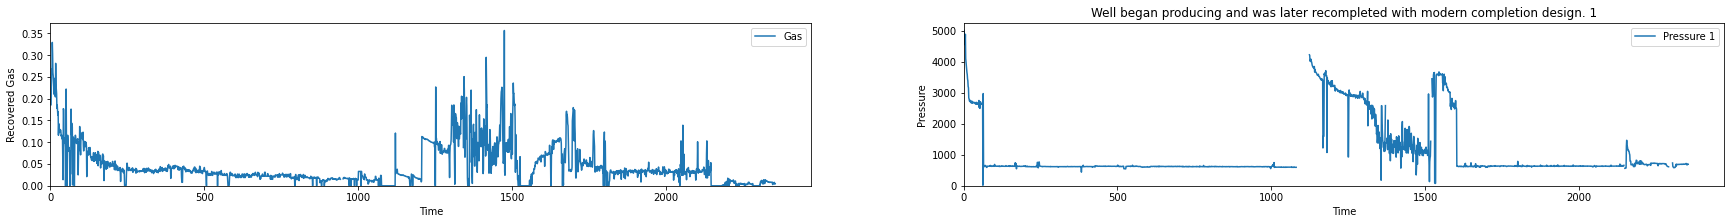

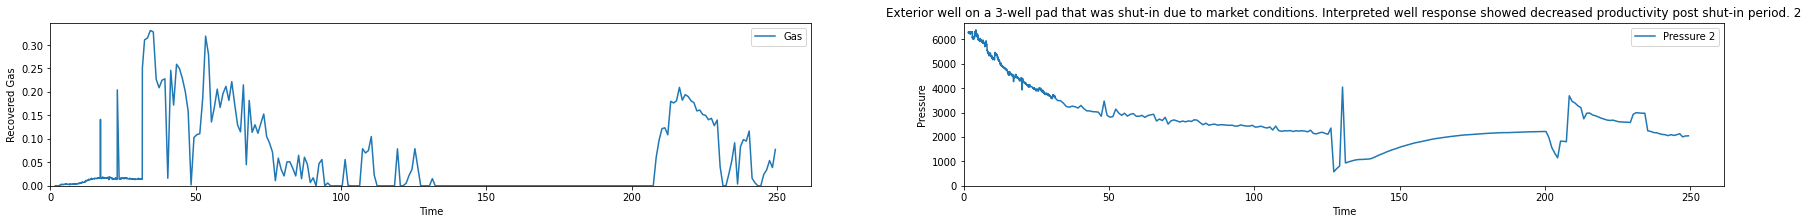

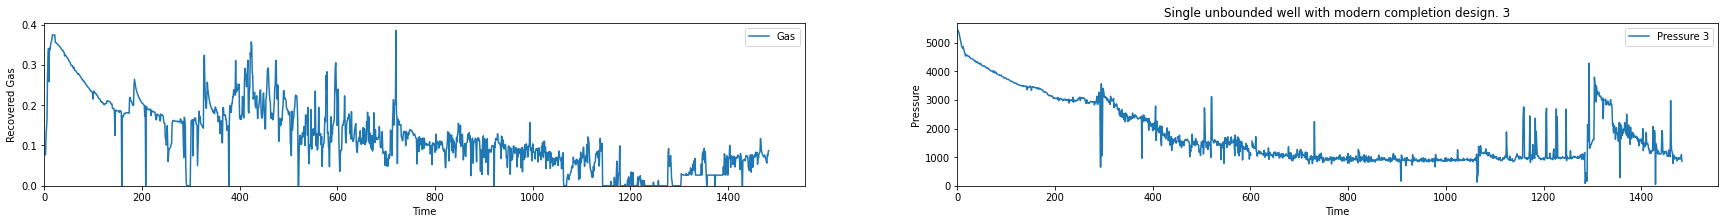

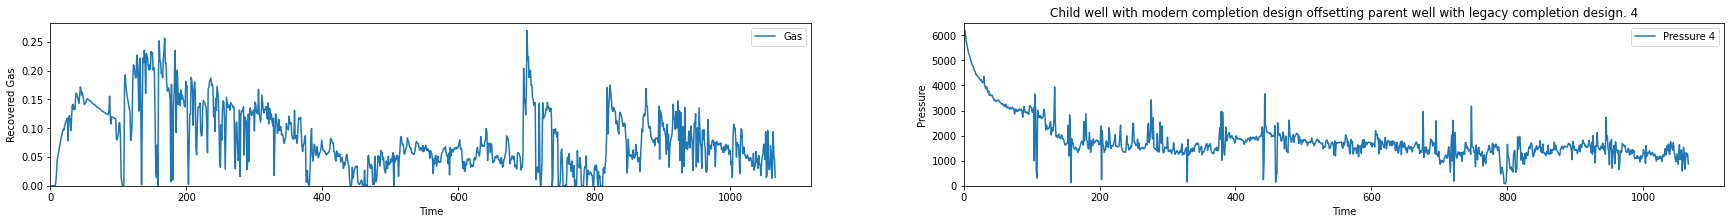

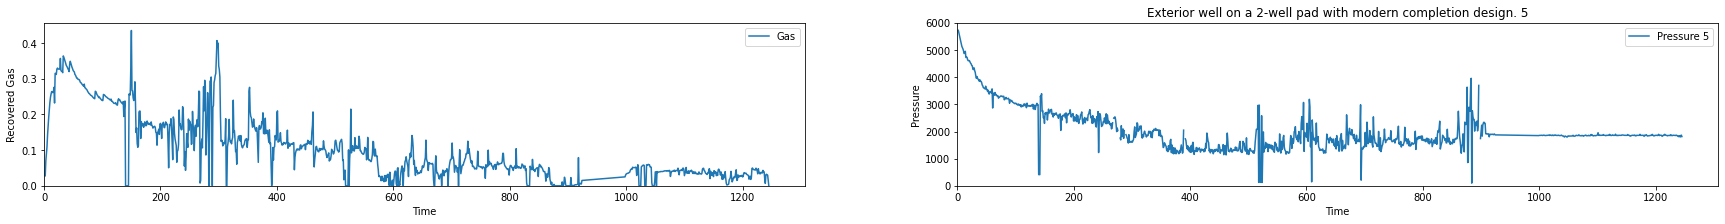

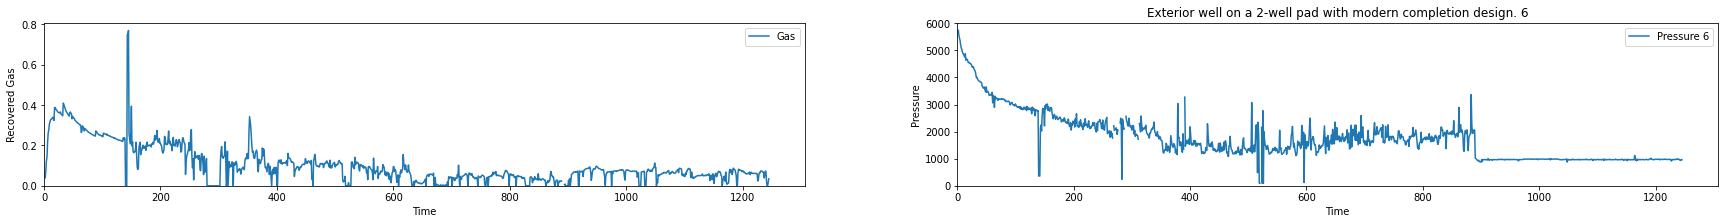

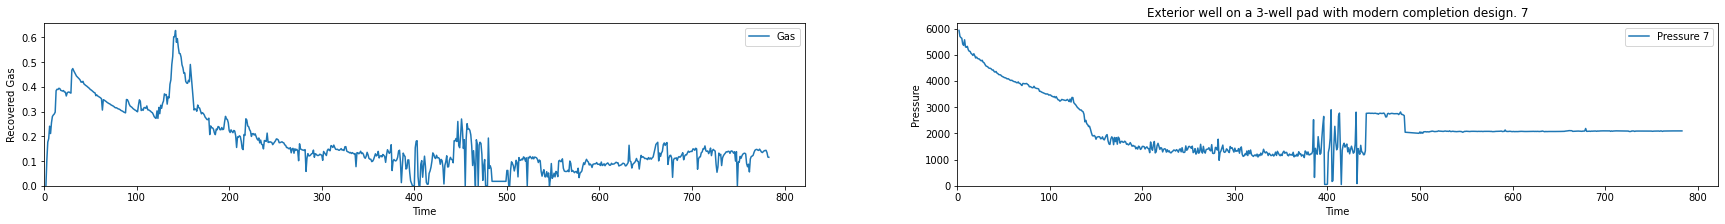

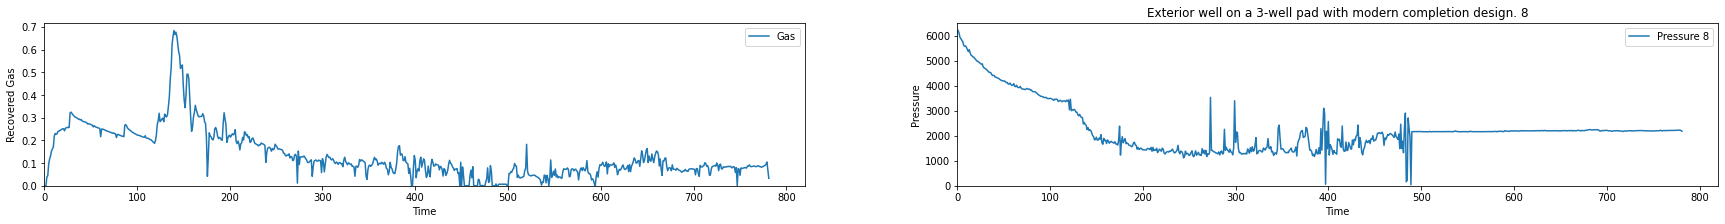

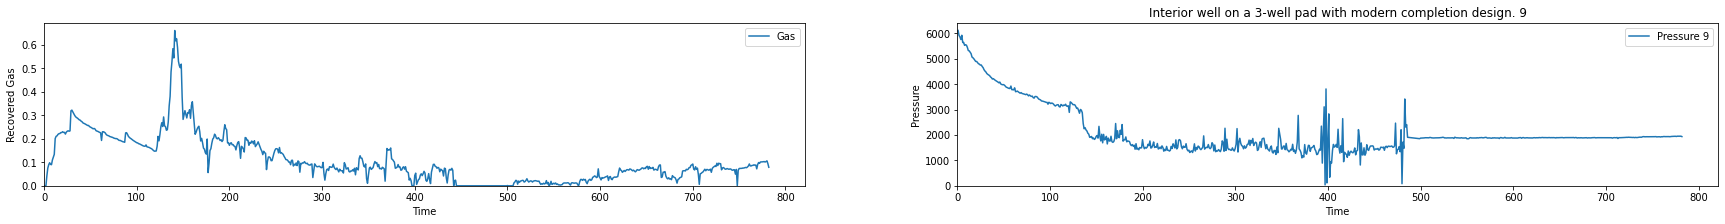

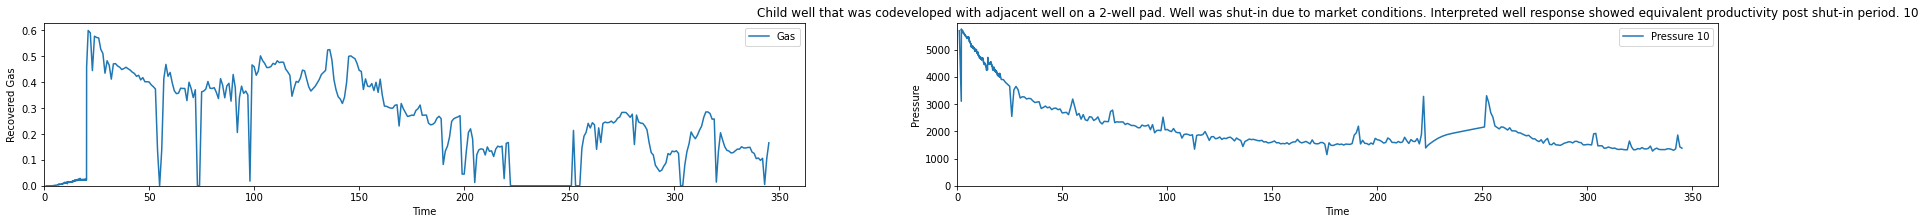

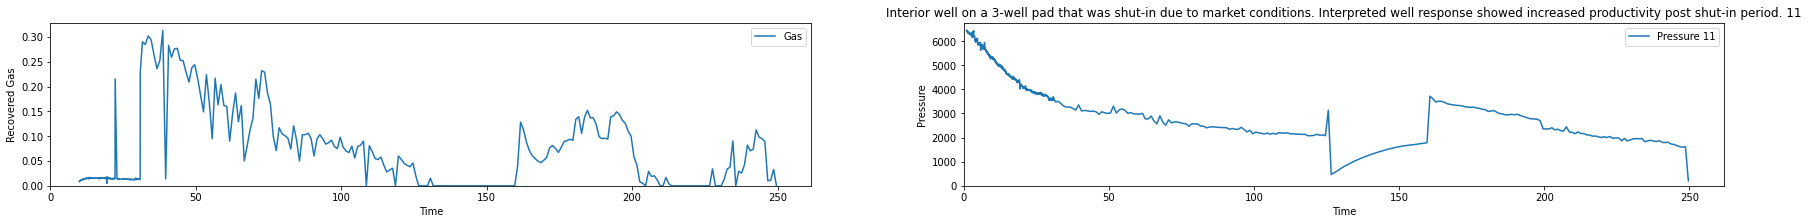

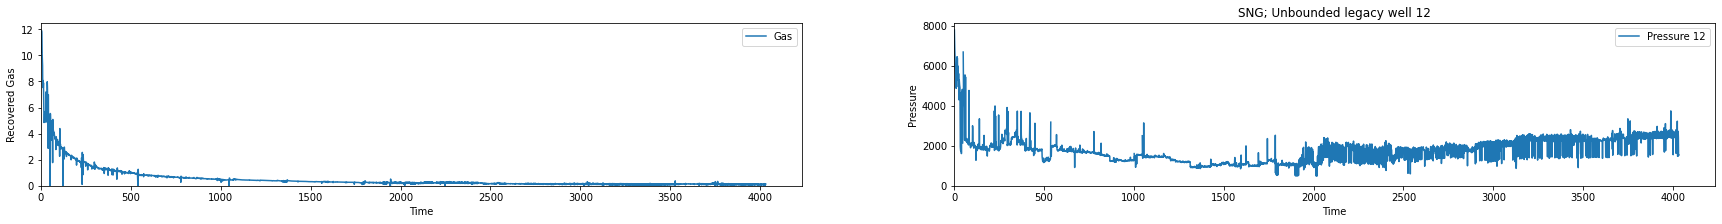

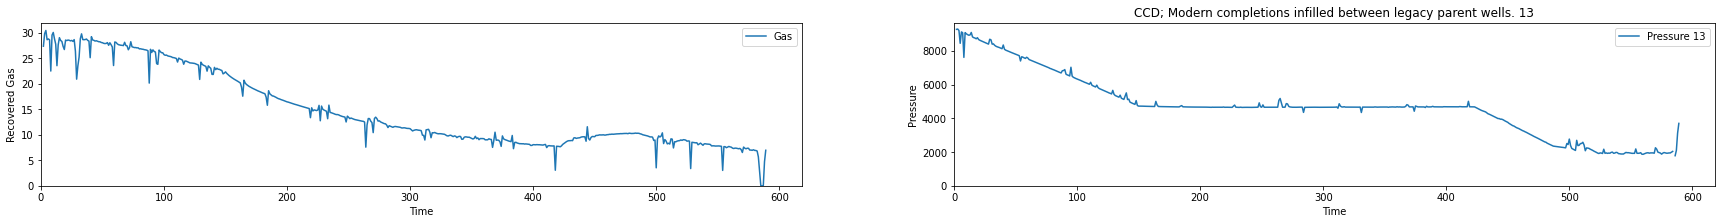

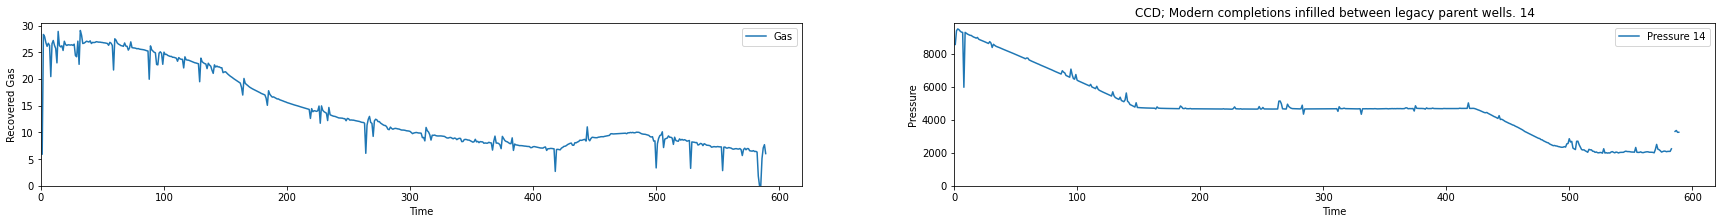

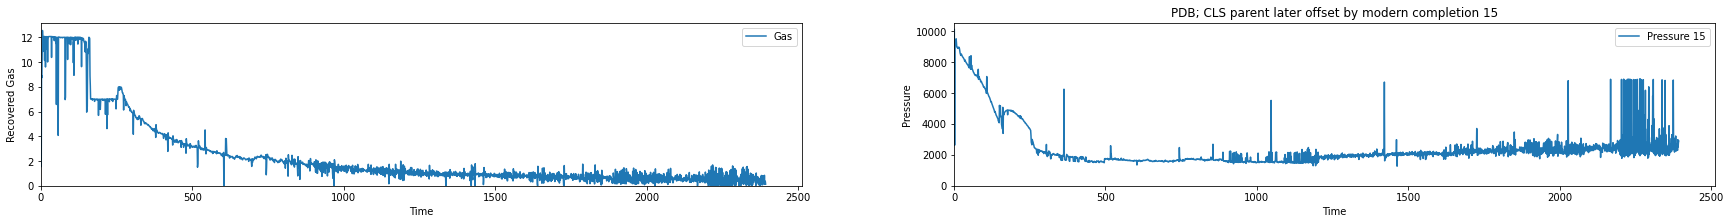

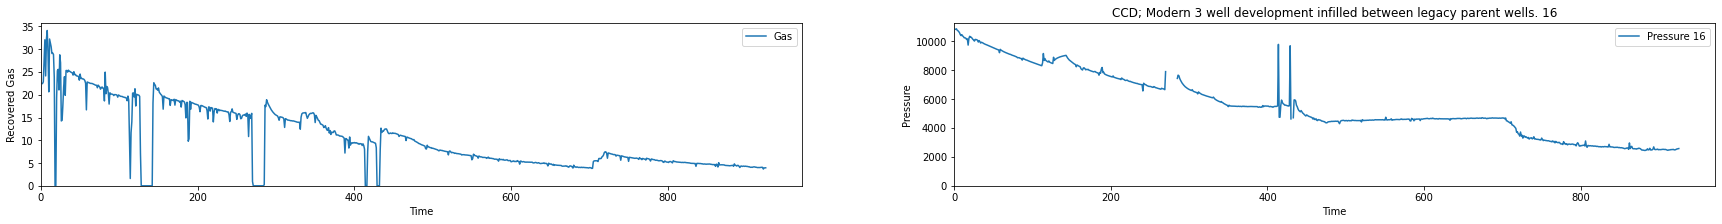

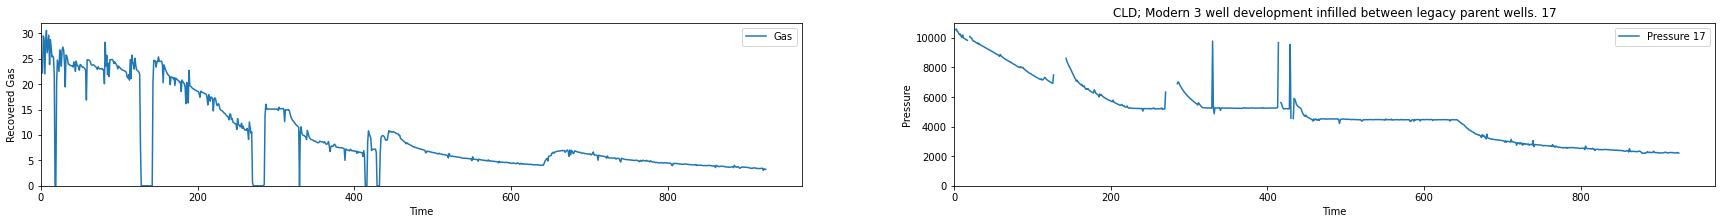

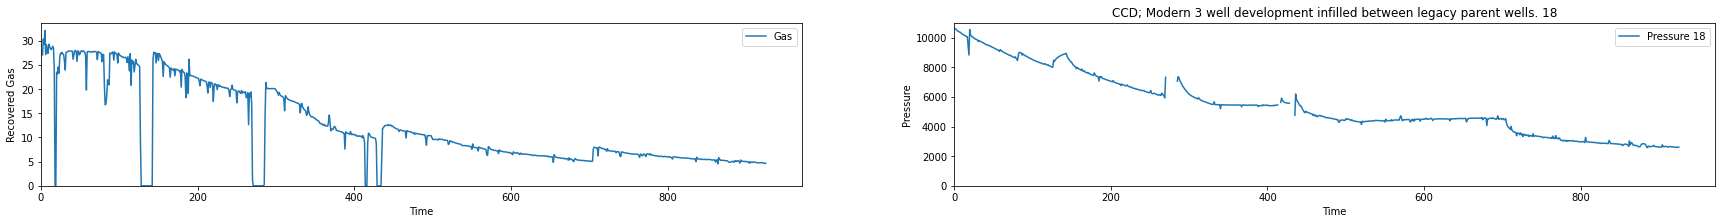

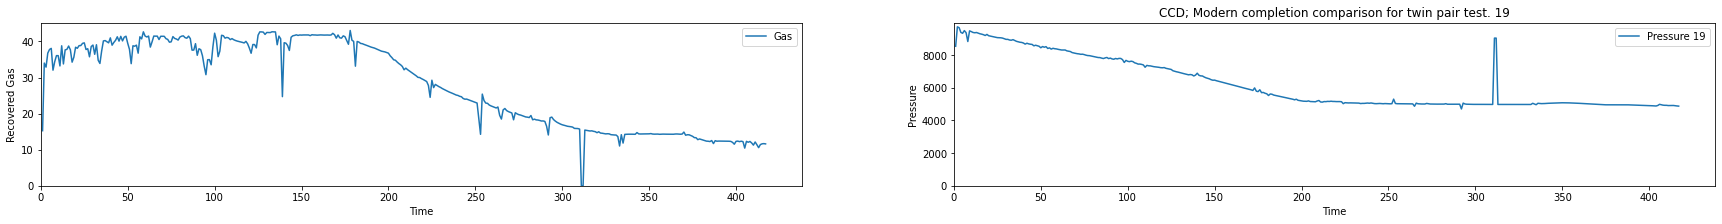

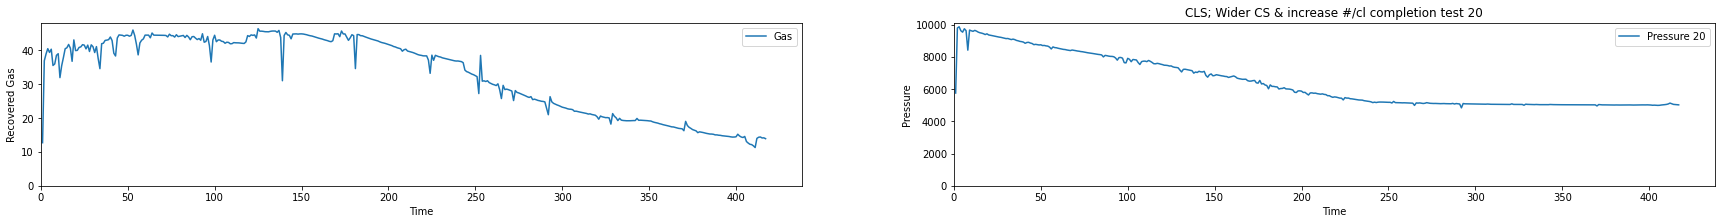

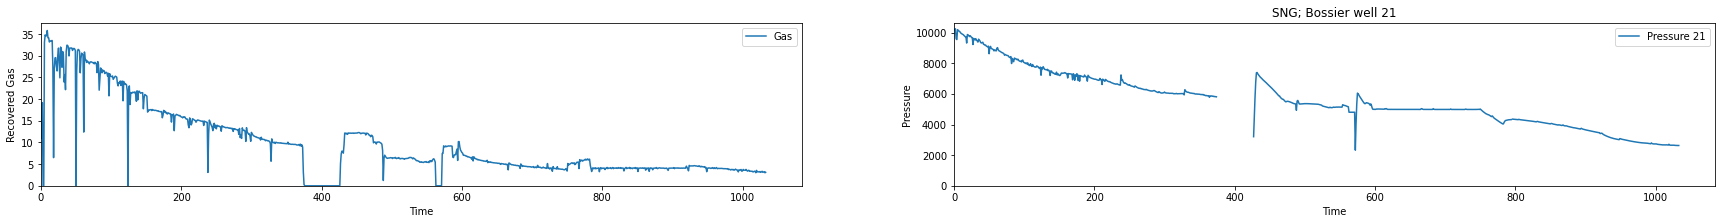

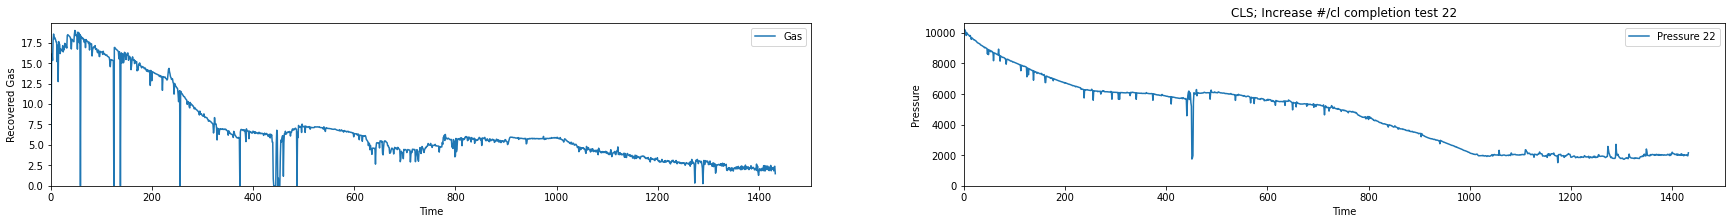

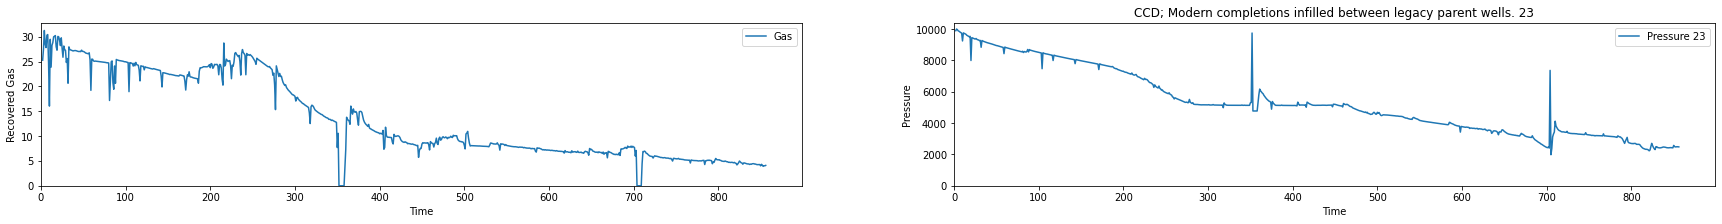

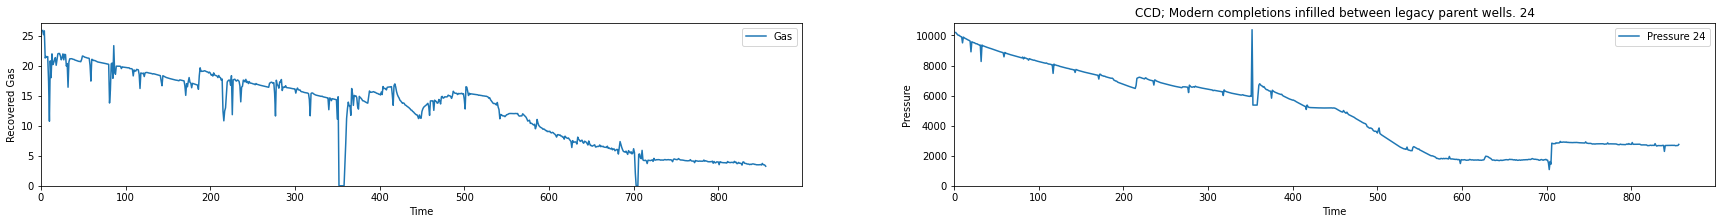

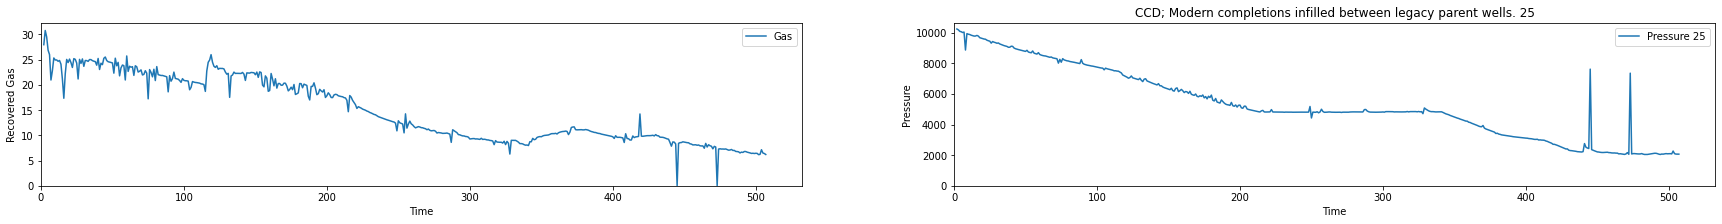

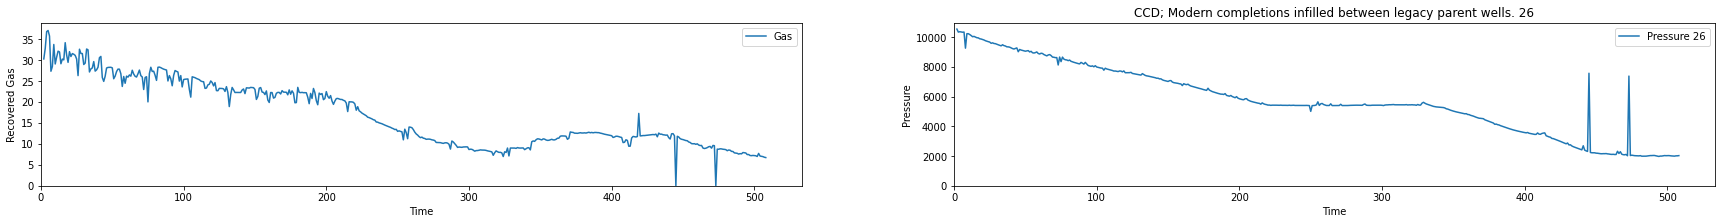

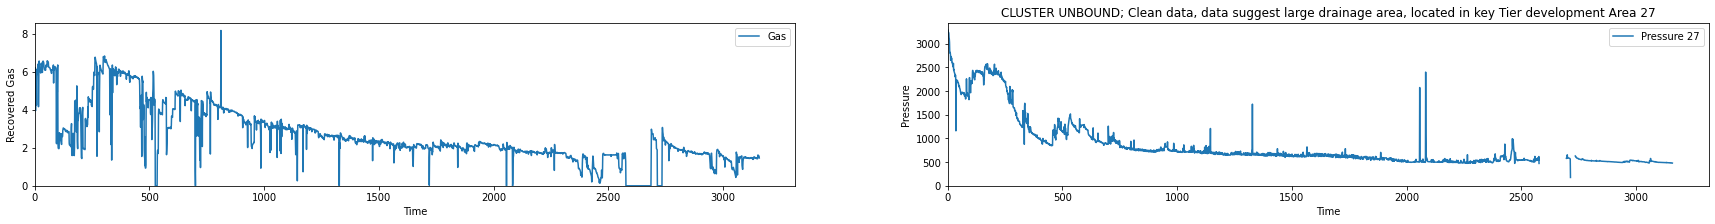

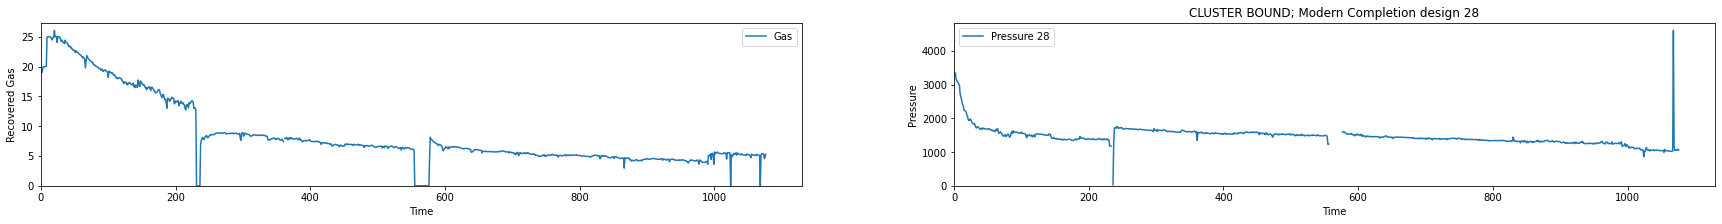

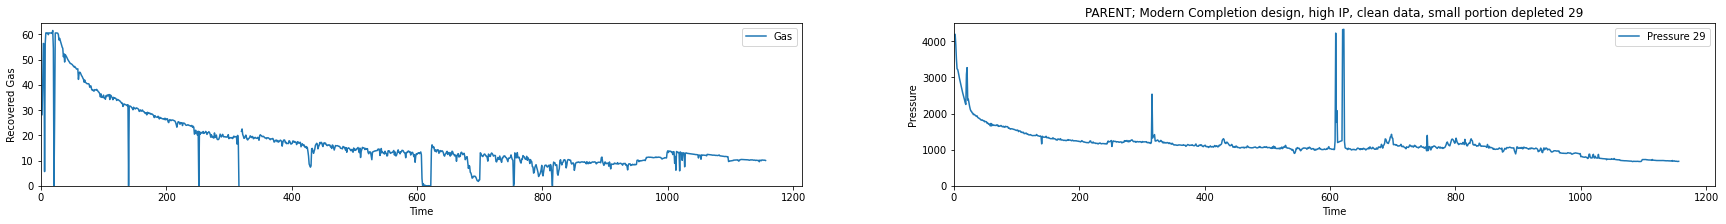

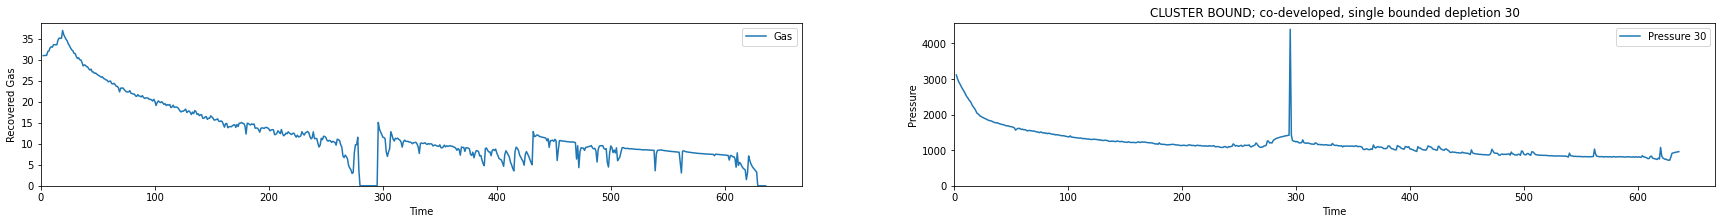

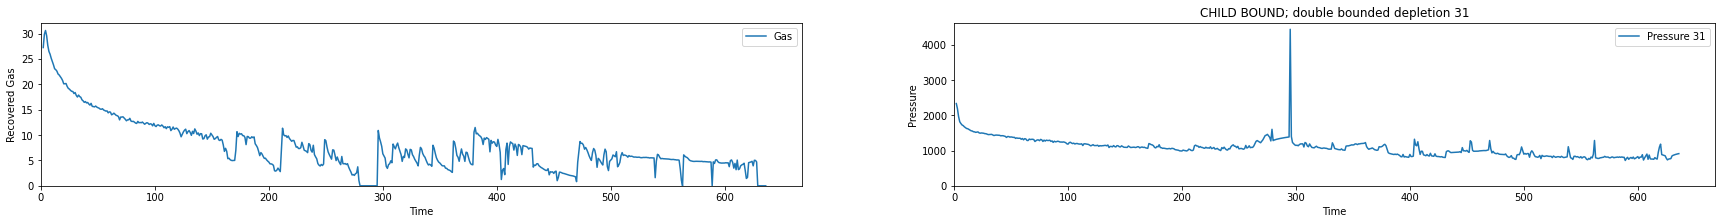

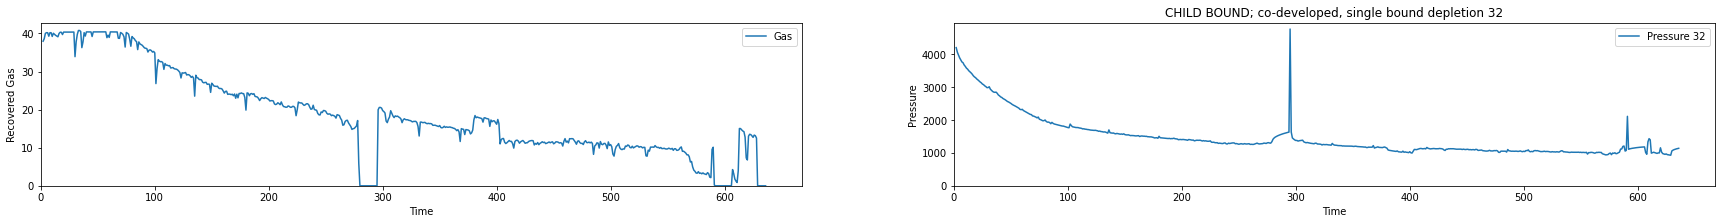

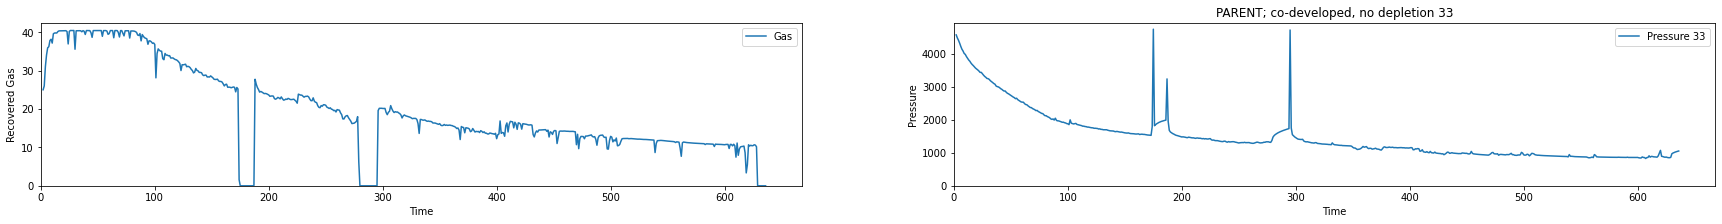

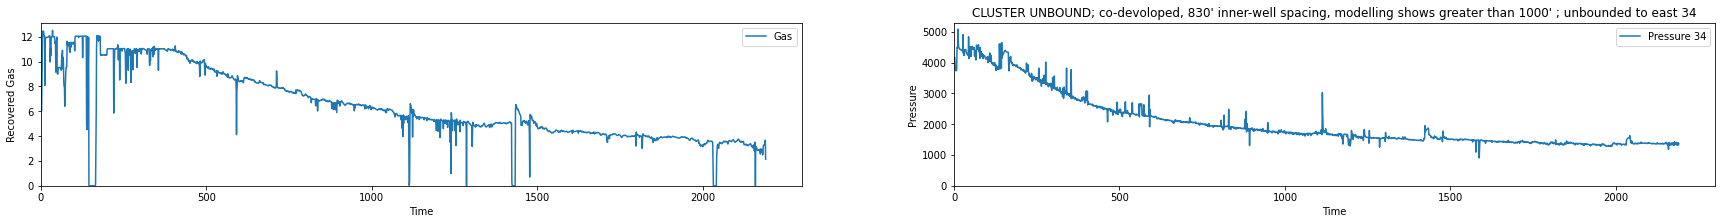

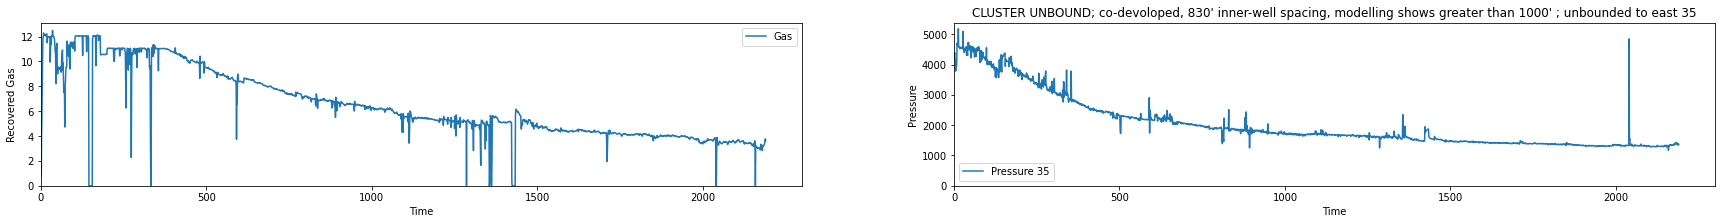

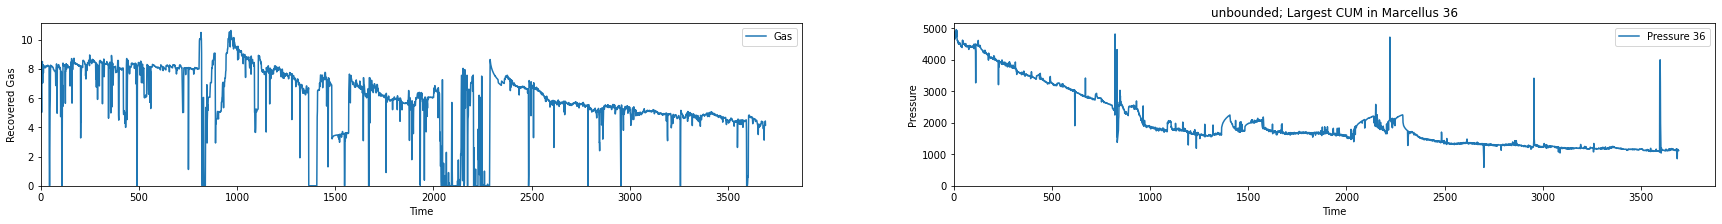

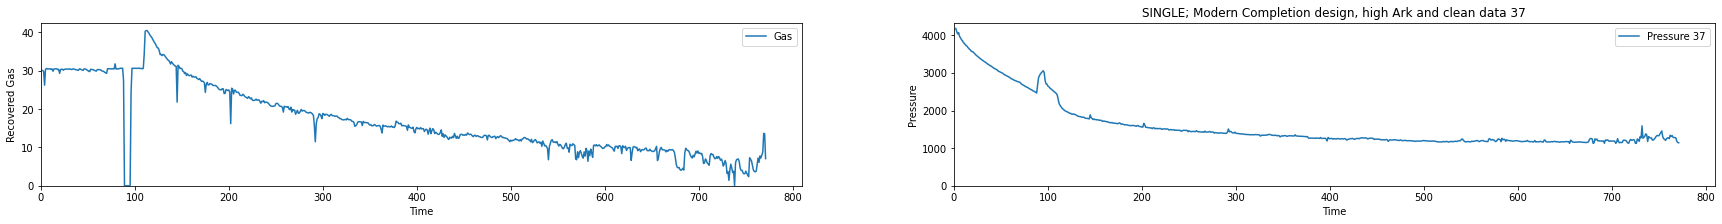

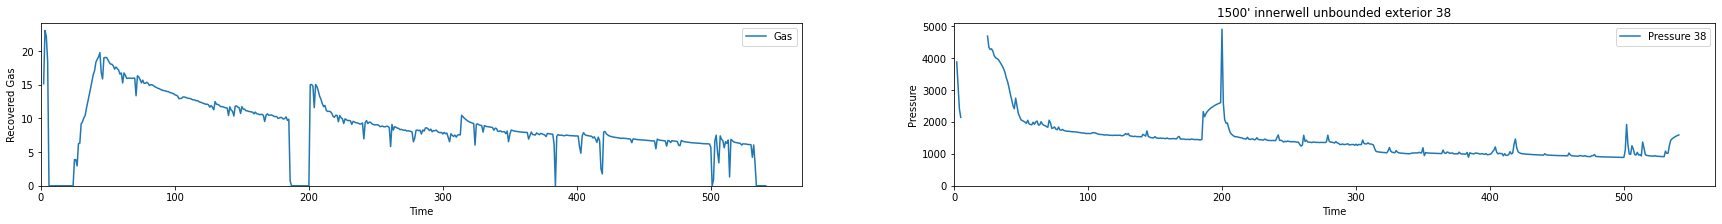

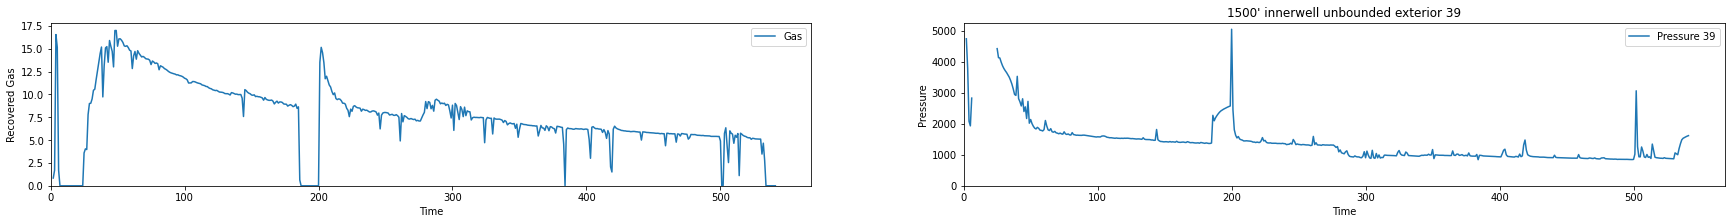

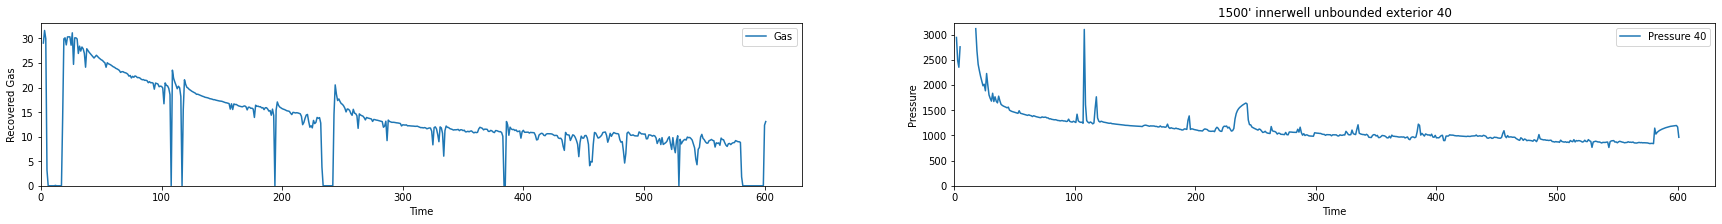

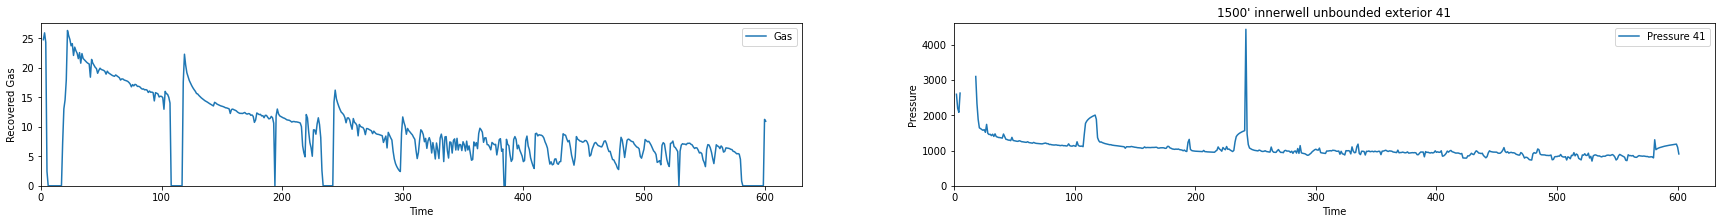

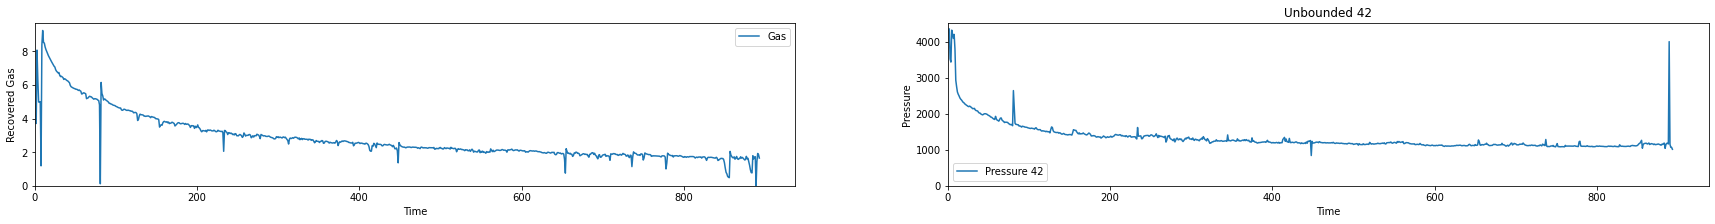

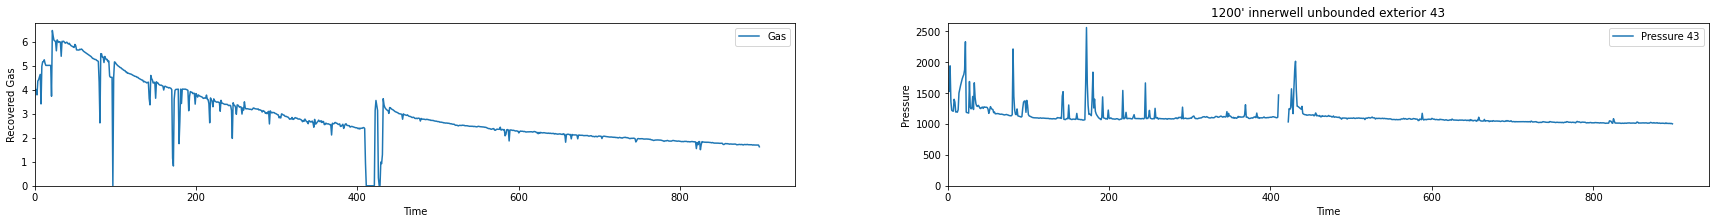

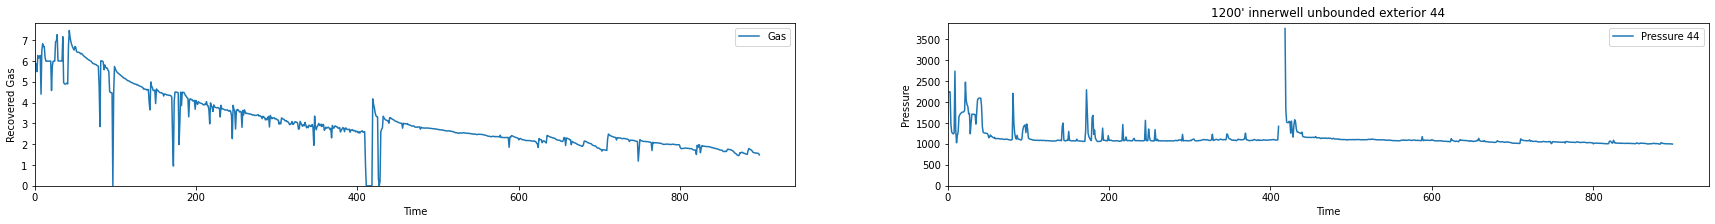

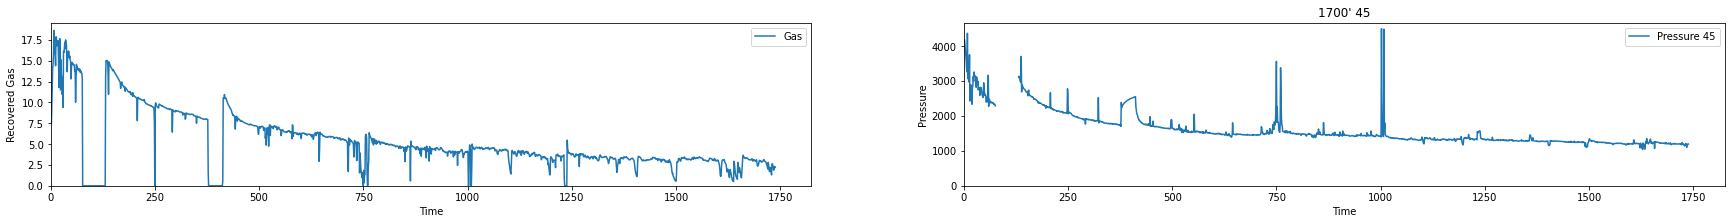

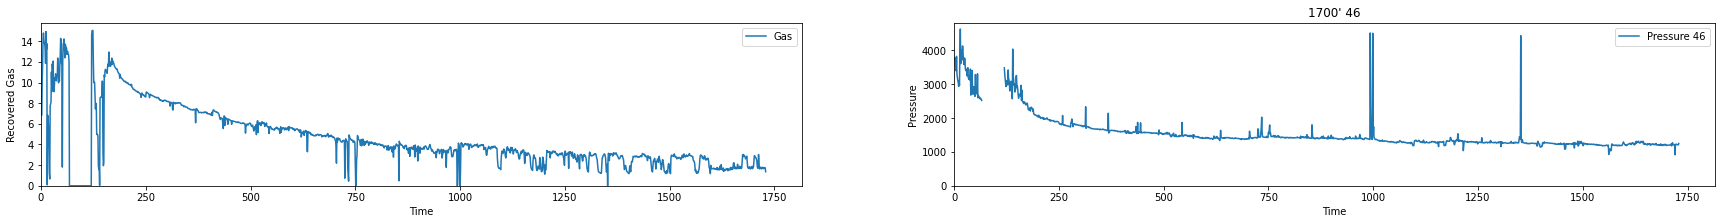

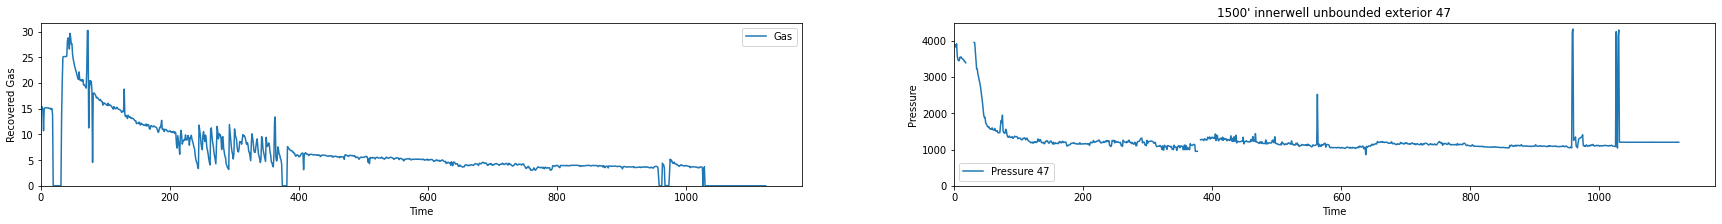

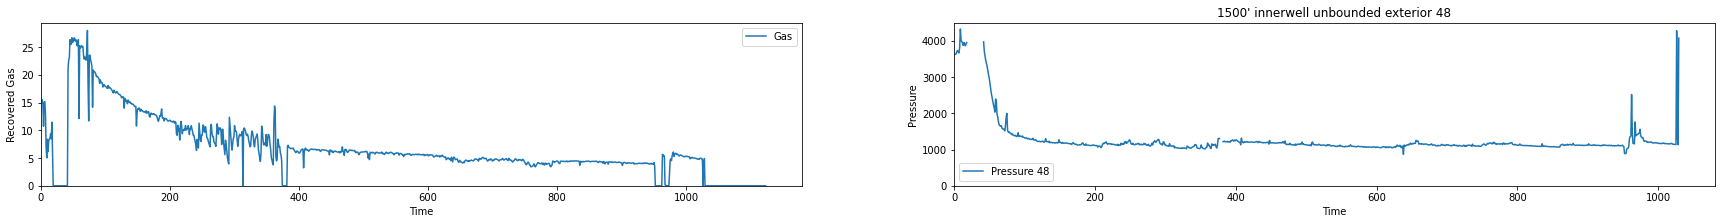

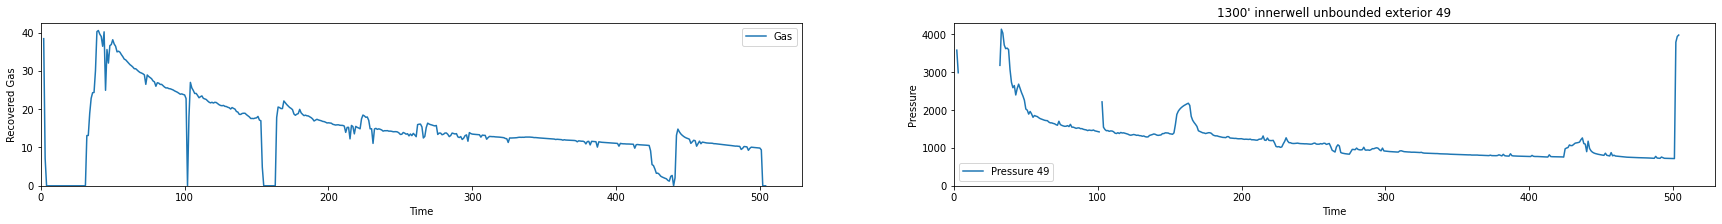

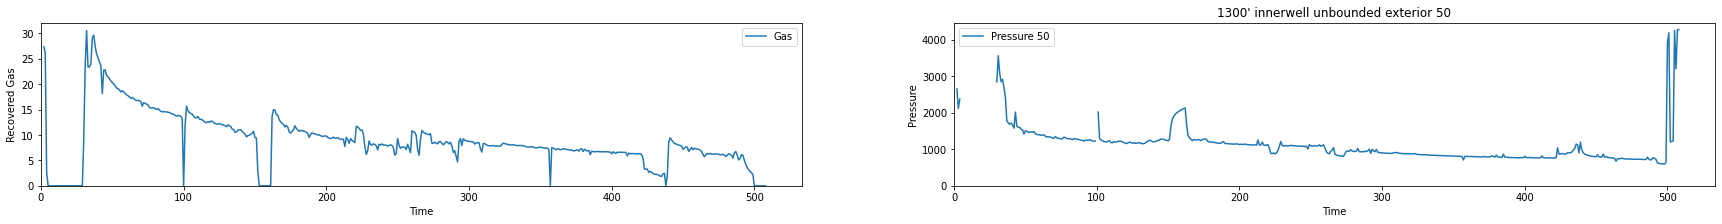

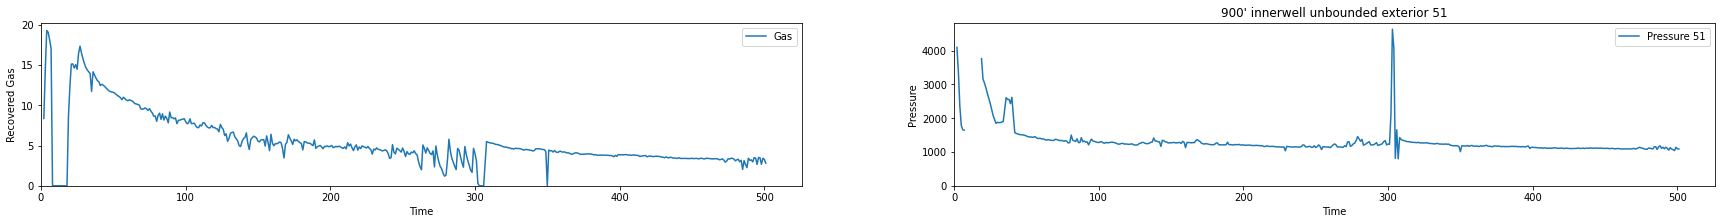

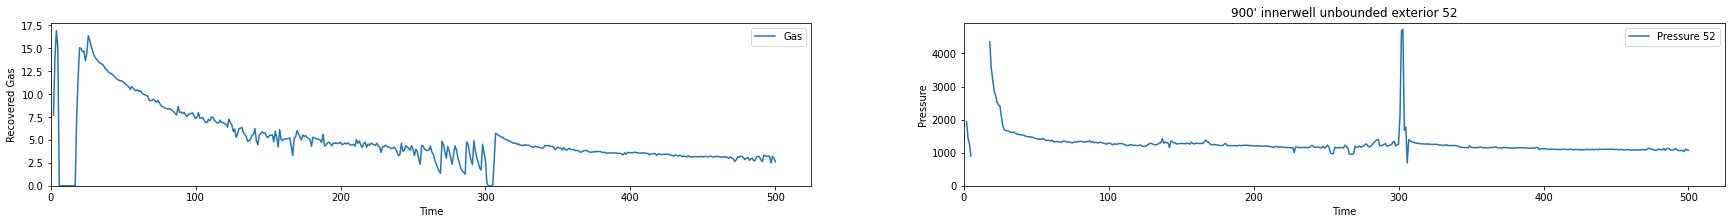

In [122]:
Type='Gas'
for WellNumber in range(1,53):
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(30, 3)
    ax1.plot(D['Days'], D[Type], label=Type)
    ax1.legend()
    ax1.set(xlabel="Time", ylabel="Recovered "+Type, ylim=(0,None), xscale='linear', xlim=(0,None))
    ax2.plot(D['Days'], D['Pressure'], label="Pressure "+str(WellNumber))
    ax2.legend()
    ax2.set(title=WellProperties.loc[WellNumber]["Comments"]+" "+str(WellNumber))
    ax2.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='linear', xlim=(0,None))


In [123]:
WellProperties.loc[1]['DayMax']=1100
WellProperties.loc[1]['DayMax']=150

In [100]:
WellNumber=4
M0=100
M=200
tau=365*(M/M0)**2

Mlib[WellNumber]=M
Taulib[WellNumber]=tau

Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
#D=pd.read_excel(open(Filename,"rb"),engine="openpyxl",skiprows=[1,2],sheet_name="Production Data")
D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E.set_index("Field")
Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

GoodDays = np.array(Data['Days'])
Days=np.arange(0,len(GoodDays))
time=np.arange(0,len(GoodDays))/tau
PressureTime=np.array(Data['Pressure'])
Gas=np.cumsum(np.array(Data['Gas']))
Pi=max(float(E.iloc[4][2]),max(PressureTime))
Pi=PressureTime[0]
Pf=PressureTime[0]
print("Initial pressure is",Pi)

pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")
ms=2*cumtrapz(pvt_gas.P/(pvt_gas.Viscosity*pvt_gas["Z-Factor"]),pvt_gas.P)
ms=np.concatenate(([0],ms))
pvt_gas.pseudopressure=ms
#pvt_gas.Cg=1./pvt_gas.P-1/pvt_gas["Z-Factor"]*Zfunc.derivative()(pvt_gas.P)
flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)

print('mf=',flow_propertiesM.m_scaled_func(Pf))
res_realgasM = SinglePhaseReservoirMarder(100, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(time,PressureTime=PressureTime)
rf2M = res_realgasM.recovery_factor()
rf2M[-1]



mf=flow_propertiesM.m_scaled_func(Pf)#Doesn't matter when pressure is varying
mi=flow_propertiesM.m_scaled_func(Pi)


remaining_gasM = (resource_left(res_realgasM.pseudopressure, flow_propertiesM) )/(density_interp(mi))
print(mf,res_realgasM.pseudopressure[-1][0],'Devation is {:5.2g}%'.format((rf2M[-1]-1+remaining_gasM[-1])/rf2M[-1]*100))
fig, ax = plt.subplots()
ax.plot(time, 1 - remaining_gasM, label="Resource left")
ax.plot(time, rf2M,"--", label="Recovery factor from frac face")
ax.plot(time, Gas/M, label="Gas")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))


fig, ax = plt.subplots()
ax.plot(time, PressureTime, label="Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))


Initial pressure is 5234.67495591206
mf= 0.448033721055063
CPU times: user 1.17 s, sys: 12.6 ms, total: 1.19 s
Wall time: 1.19 s
1.558388040799884


ValueError: A value in x_new is above the interpolation range.

In [3]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")
ms=2*cumtrapz(pvt_gas.P/(pvt_gas.Viscosity*pvt_gas["Z-Factor"]),pvt_gas.P)
ms=np.concatenate(([0],ms))
pvt_gas.pseudopressure=ms
#pvt_gas.Cg=1./pvt_gas.P-1/pvt_gas["Z-Factor"]*Zfunc.derivative()(pvt_gas.P)

M0=10
MMax=100000

In [94]:
WellNumber=28
from FitFunctions import obfun


for WellNumber in range(16,20):
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    E.set_index("Field")
    Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

    GoodDays = np.array(Data['Days'])
    Days=np.arange(0,len(GoodDays))
    PressureTime=np.array(Data['Pressure'])
    #
    Nave=30
    PressureTime=sp.ndimage.filters.uniform_filter1d(PressureTime, size=Nave)
    #
    Gas=np.cumsum(np.array(Data['Gas']))

    if (WellNumber<12): #the low numbers are oil wells
        Pi=PressureTime[0]
    else:
        Pi=max(float(E.iloc[4][2]),max(PressureTime))
    Pf=Pi

    if (WellNumber in Results.keys()):
        params=Results[WellNumber].params
        NTimes=50
    else:
        params=Parameters()
        params.add('tau',value=1000.0,min=30.0,max=Days[-1]*2) #Days
        params.add('M',value=Gas[-1],min=Gas[-2],max=MMax) #MMcf
        params.add('Pi',value=Pi,min=max(PressureTime),max=12000) #MMcf
        NTimes=200
    mini=Minimizer(obfun,params,fcn_args=(Days,Gas,pvt_gas,PressureTime))
    result=mini.minimize(method='Nelder',max_nfev=NTimes)
    print('Finished Nelder minimization with tau={:7.5g}, Pi={:7.5g} and M={:8.5g}'.format(result.params['tau'].value,result.params['Pi'].value,result.params['M'].value))
    #result=mini.minimize(method='leastsq',xtol=1.e-4,params=result.params)
    #print('Finished lstsqr minimization with tau={:5.2g} and M={:5.2g}'.format(result.params['tau'].value,result.params['M'].value))
    print(' ##### {:} #####'.format(WellNumber))
    Results[WellNumber]=result

Simulation took   1.5 s; tau is    1000, Pi is   11325 and M is  9749.4
Simulation took   1.4 s; tau is    1005, Pi is   11325 and M is  9749.4
Simulation took   1.3 s; tau is    1000, Pi is   11325 and M is  9839.6
Simulation took   1.3 s; tau is    1000, Pi is   11329 and M is  9749.4
Simulation took   1.3 s; tau is  995.02, Pi is   11328 and M is  9779.2
Simulation took   1.4 s; tau is  996.68, Pi is   11329 and M is  9866.6
Simulation took   1.3 s; tau is  995.02, Pi is   11331 and M is   10052
Simulation took   1.3 s; tau is  993.36, Pi is   11327 and M is   10321
Simulation took   1.3 s; tau is  990.04, Pi is   11326 and M is   11108
Simulation took   1.2 s; tau is  995.02, Pi is   11328 and M is   11108
Simulation took   1.2 s; tau is  986.71, Pi is   11332 and M is   12352
Simulation took   1.2 s; tau is  980.06, Pi is   11335 and M is   14845
Simulation took   1.3 s; tau is  981.73, Pi is   11328 and M is   15980
Simulation took   1.3 s; tau is  975.07, Pi is   11326 and M is 

CPU times: user 1.29 s, sys: 7.98 ms, total: 1.29 s
Wall time: 1.3 s
tau= 138.48, Pi=  11004 and M=   37813
CPU times: user 2.66 s, sys: 13.5 ms, total: 2.67 s
Wall time: 2.68 s
tau=  119.9, Pi=  12000 and M=   20976
CPU times: user 2.97 s, sys: 18 ms, total: 2.99 s
Wall time: 3 s
tau= 242.57, Pi=  10485 and M=   17559
CPU times: user 2.44 s, sys: 11.7 ms, total: 2.45 s
Wall time: 2.46 s
tau= 85.592, Pi=  12000 and M=   21364
CPU times: user 1.07 s, sys: 6.53 ms, total: 1.07 s
Wall time: 1.08 s
tau= 695.34, Pi= 4480.9 and M=   26253
CPU times: user 2.44 s, sys: 15 ms, total: 2.46 s
Wall time: 2.47 s
tau= 3854.7, Pi= 3005.1 and M=   16660
CPU times: user 1.33 s, sys: 7.13 ms, total: 1.34 s
Wall time: 1.34 s
tau= 1184.9, Pi= 3213.3 and M=   21920
CPU times: user 1.18 s, sys: 7.86 ms, total: 1.19 s
Wall time: 1.19 s
tau= 1409.1, Pi= 4166.9 and M=   41033
CPU times: user 831 ms, sys: 4.53 ms, total: 835 ms
Wall time: 836 ms
tau= 752.38, Pi= 3440.3 and M=   16804
CPU times: user 801 ms, sys

/var/folders/mv/xtq5fvh134qc0zf3xwhl7ps80000gn/T/ipykernel_4563/530083289.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(2,1)


CPU times: user 1.46 s, sys: 8.06 ms, total: 1.46 s
Wall time: 1.47 s
tau= 975.13, Pi= 1799.7 and M=  8227.3
CPU times: user 1.96 s, sys: 10.9 ms, total: 1.97 s
Wall time: 1.98 s
tau= 1443.2, Pi= 4264.7 and M=   18223
CPU times: user 1.97 s, sys: 11.3 ms, total: 1.98 s
Wall time: 1.99 s
tau=   1564, Pi= 4129.7 and M=   15916
CPU times: user 1.32 s, sys: 10 ms, total: 1.33 s
Wall time: 1.33 s
tau= 1003.2, Pi= 3897.2 and M=   14078
CPU times: user 1.29 s, sys: 7.55 ms, total: 1.3 s
Wall time: 1.31 s
tau= 1000.8, Pi= 3854.5 and M=   14707
CPU times: user 783 ms, sys: 12.4 ms, total: 795 ms
Wall time: 797 ms
tau= 804.74, Pi=   3534 and M=   18072
CPU times: user 849 ms, sys: 4.47 ms, total: 854 ms
Wall time: 855 ms
tau=    469, Pi= 2563.4 and M=    9220
CPU times: user 632 ms, sys: 3.17 ms, total: 635 ms
Wall time: 637 ms
tau= 965.39, Pi= 4859.5 and M=  6982.9
CPU times: user 728 ms, sys: 4.35 ms, total: 732 ms
Wall time: 734 ms
tau=  962.1, Pi= 2809.2 and M=  7494.5


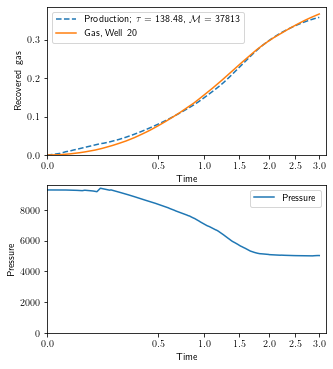

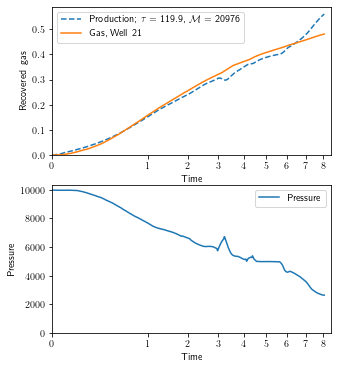

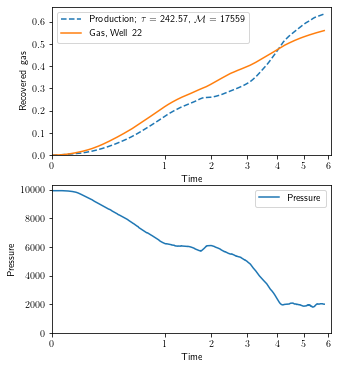

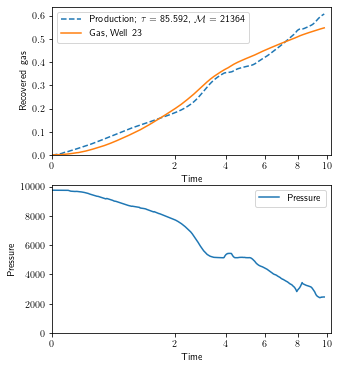

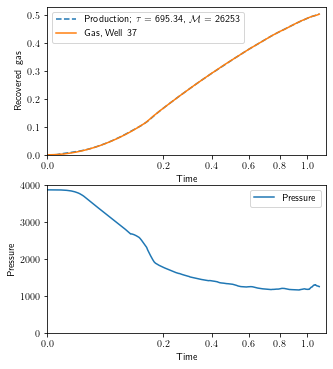

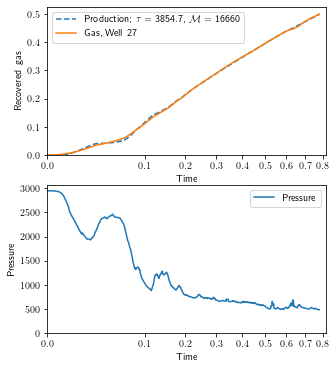

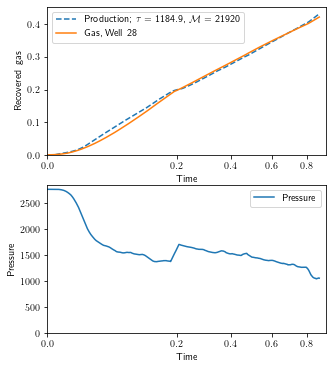

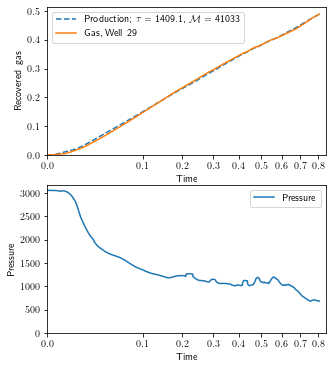

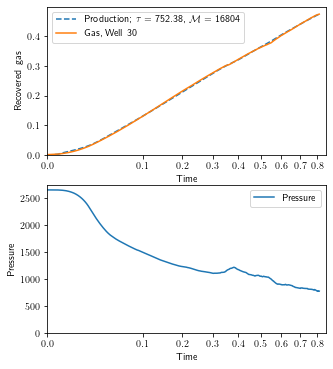

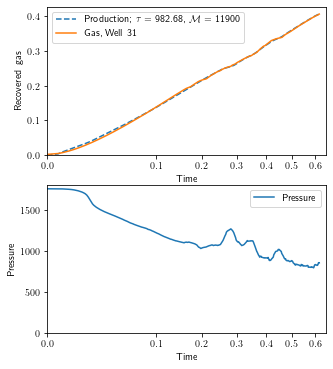

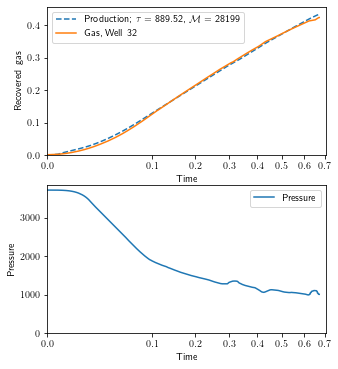

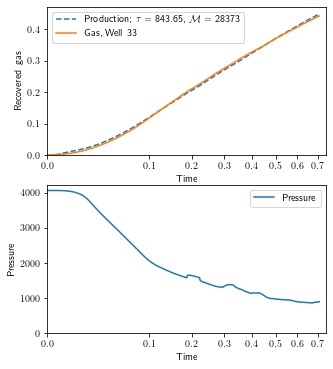

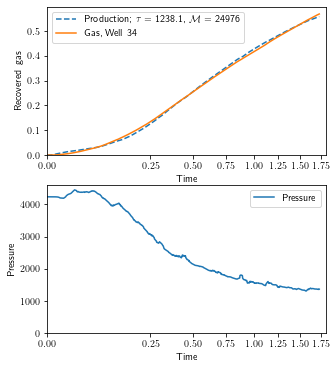

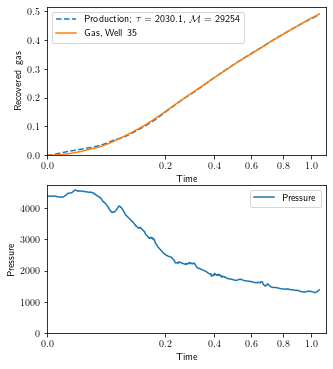

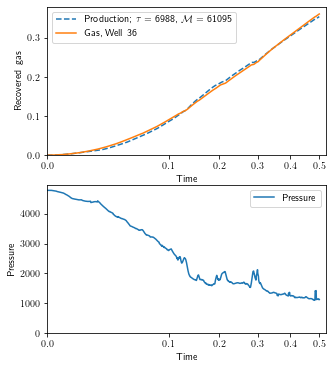

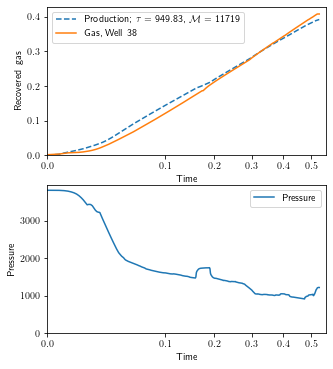

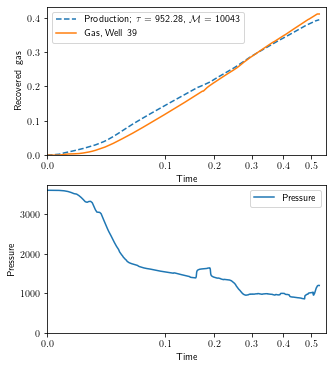

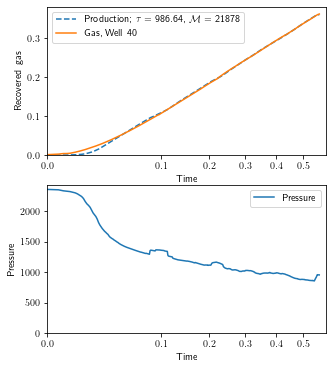

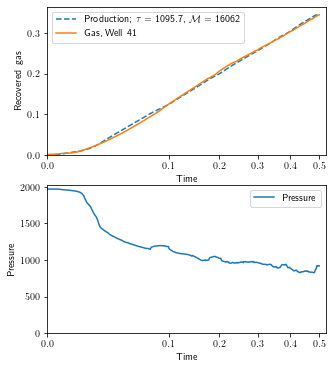

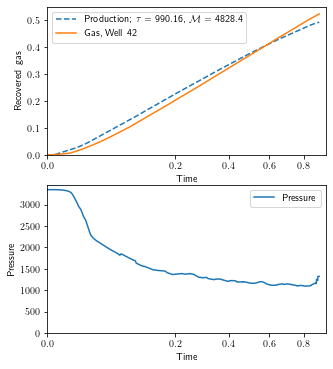

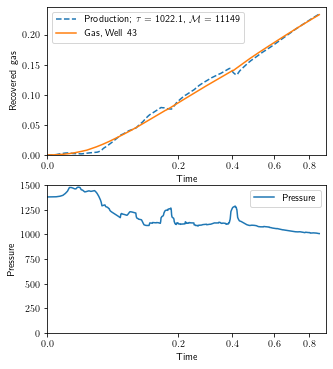

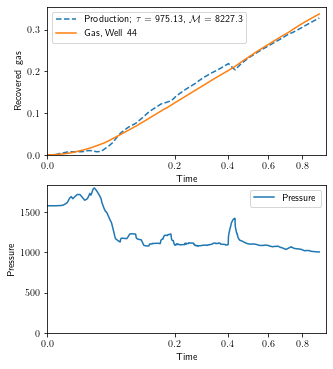

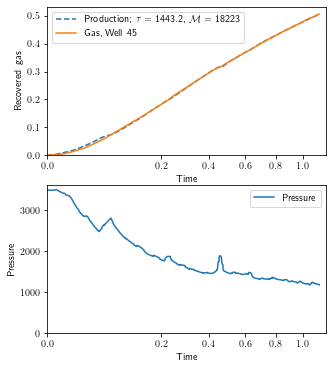

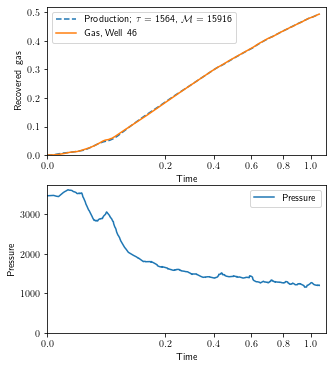

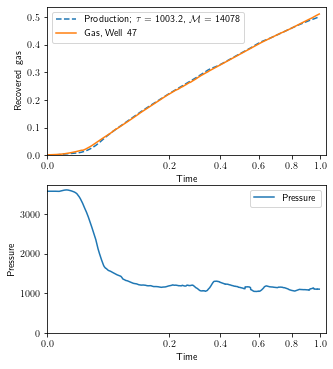

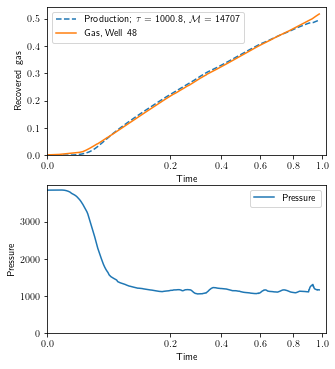

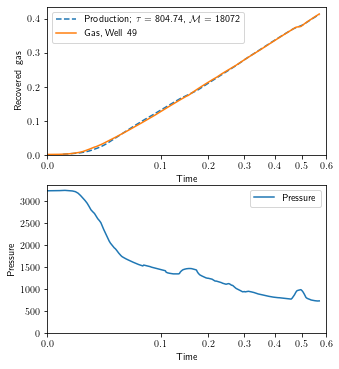

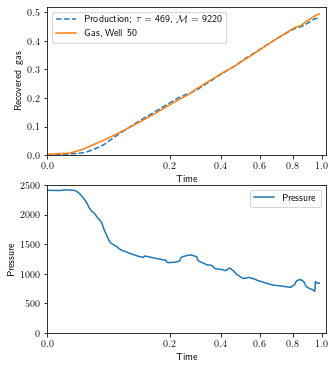

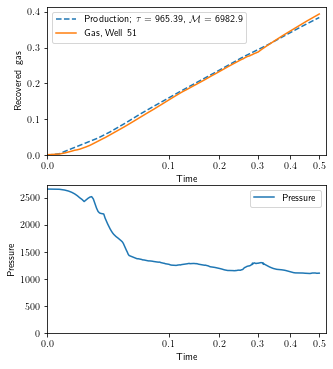

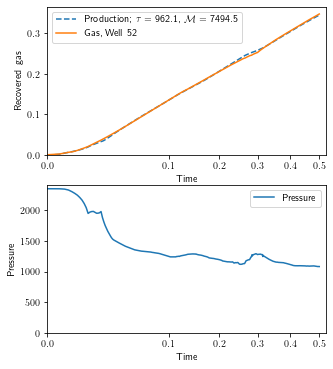

In [93]:
plt.rcParams['text.usetex'] = True
for WellNumber in range(16,20):#Results.keys():
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    E.set_index("Field")
    Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

    GoodDays = np.array(Data['Days'])
    Days=np.arange(0,len(GoodDays))
    PressureTime=np.array(Data['Pressure'])
    #
    Nave=30
    PressureTime=sp.ndimage.filters.uniform_filter1d(PressureTime, size=Nave)
    #
    Gas=np.cumsum(np.array(Data['Gas']))
    M=Results[WellNumber].params['M'].value
    tau=Results[WellNumber].params['tau'].value
    Pi=Results[WellNumber].params['Pi'].value
    Pf=Pi

    flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)
    res_realgasM = SinglePhaseReservoirMarder(80, Pf, Pi, flow_propertiesM)
    %time res_realgasM.simulate(Days/tau,PressureTime=PressureTime)
    print('tau={:7.5g}, Pi={:7.5g} and M={:8.5g}'.format(tau,Pi,M))
    rf2M = res_realgasM.recovery_factor()
    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(5, 6)
    ax1.plot(Days/tau, rf2M,"--", label=r"Production; $\tau=${:7.5g}, $\mathcal M=${:7.5g}".format(tau,M))
    ax1.plot(Days/tau, Gas/M, label="Gas, Well "+str(WellNumber))
    ax1.legend()
    ax1.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

    ax2.plot(Days/tau, PressureTime, label="Pressure")
    ax2.legend()
    ax2.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))

    pp=PdfPages('Wells'+str(WellNumber)+'.pdf')
    pp.savefig(fig)
    pp.close()


In [37]:
Results[21].params['tau'].value=500

CPU times: user 1.75 s, sys: 64.9 ms, total: 1.81 s
Wall time: 1.81 s
tau is   242.57 and M is 1.76e+04


[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Pressure'),
 (0.0, 10332.935043872363),
 None,
 (0.0, 6.129358634652561)]

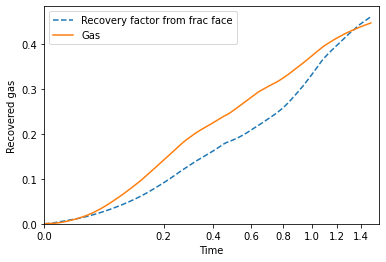

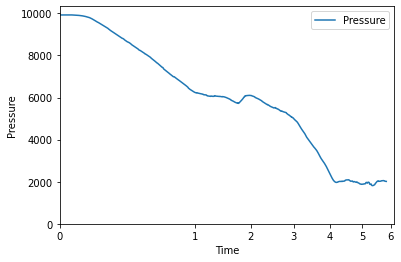

In [63]:
Pi=12000
Pf=Pi
M2=22000
tau2=950

flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)
res_realgasM = SinglePhaseReservoirMarder(80, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(Days/tau2,PressureTime=PressureTime)
print("tau is {:8.6g} and M is {:5.3g}".format(tau,M))
rf2M = res_realgasM.recovery_factor()
fig, ax = plt.subplots()
ax.plot(Days/tau2, rf2M,"--", label="Recovery factor from frac face")
ax.plot(Days/tau2, Gas/M2, label="Gas")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))


fig, ax = plt.subplots()
ax.plot(Days/tau, PressureTime, label="Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))


[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Pressure'),
 (0.0, 8070.94802),
 None,
 (0.0, 437.8)]

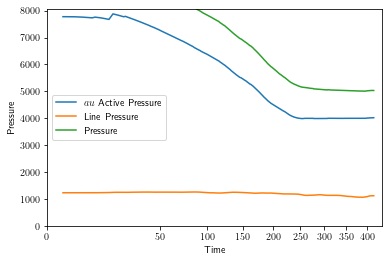

In [89]:
WellNumber=20
F= sp.ndimage.filters.uniform_filter1d 
Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
#print(D)

fig, ax = plt.subplots()
ax.plot(D["Days"], F(D["Active Pressure"],size=30), label=r"$\tau$ Active Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel=r"\tau Active Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))


ax.plot(D["Days"], F(D["Line Pressure"],size=30), label="Line Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel=r"\tau", ylim=(0,None), xscale='squareroot', xlim=(0,None))

ax.plot(D["Days"], F(D["Pressure"],size=30), label="Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))



In [76]:

pkl.dump(Results,file=open("Results.pkl","wb"))

In [61]:
dir(time)

['CLOCK_MONOTONIC',
 'CLOCK_MONOTONIC_RAW',
 'CLOCK_PROCESS_CPUTIME_ID',
 'CLOCK_REALTIME',
 'CLOCK_THREAD_CPUTIME_ID',
 'CLOCK_UPTIME_RAW',
 '_STRUCT_TM_ITEMS',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'altzone',
 'asctime',
 'clock_getres',
 'clock_gettime',
 'clock_gettime_ns',
 'clock_settime',
 'clock_settime_ns',
 'ctime',
 'daylight',
 'get_clock_info',
 'gmtime',
 'localtime',
 'mktime',
 'monotonic',
 'monotonic_ns',
 'perf_counter',
 'perf_counter_ns',
 'process_time',
 'process_time_ns',
 'sleep',
 'strftime',
 'strptime',
 'struct_time',
 'thread_time',
 'thread_time_ns',
 'time',
 'time_ns',
 'timezone',
 'tzname',
 'tzset']